In [24]:
from fastkaggle import *
from fastai.vision.all import *
# from fastai.medical.imaging import *
from fastai.data.all import *
from tqdm.notebook import tqdm
import pydicom
from PIL import Image

In [97]:
train_path = Path("data")
bs = 16
epochs = 1
# arch = 'resnet26d'
arch = 'convnext_tiny_in22k'

In [12]:
annotations = pd.read_csv(path/"finding_annotations.csv")
annotations.head(10)

study_id                         series_id  \
0  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
1  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
2  75e8e48933289d70b407379a564f8594  853b70e7e6f39133497909d9ca4c756d   
3  75e8e48933289d70b407379a564f8594  853b70e7e6f39133497909d9ca4c756d   
4  c3487424fee1bdd4515b72dc3fd69813  77619c914263eae44e9099f1ce07192c   
5  c3487424fee1bdd4515b72dc3fd69813  77619c914263eae44e9099f1ce07192c   
6  5683854eafabc34f6d854000d2ac6c2d  4ac33111294b83d43537cb8604b0808c   
7  5683854eafabc34f6d854000d2ac6c2d  4ac33111294b83d43537cb8604b0808c   
8  7c51789da6c462e55bcb95c2a7d437ee  ac4d0771f6d7a7400ab463458f789dbe   
9  7c51789da6c462e55bcb95c2a7d437ee  ac4d0771f6d7a7400ab463458f789dbe   

                           image_id laterality view_position  height  width  \
0  4e3a578fe535ea4f5258d3f7f4419db8          R            CC    3518   2800   
1  dac39351b0f3a8c670b7f8dc88029364          R           MLO    3518   2800   
2  c83f780904f25eacb44e9030f32c66e1          R            CC    3518   2800   
3  893528bc38a0362928a89364f1b692fd          R           MLO    3518   2800   
4  318264c881bf12f2c1efe5f93920cc37          R            CC    3518   2800   
5  adf961b5379855af0293ca526f3d0c51          R           MLO    3518   2800   
6  2f944efb1cb9579442df2d7fe6a579b7          L            CC    3518   2800   
7  7385e8cf7b29764525c81de4aa1aebe4          L           MLO    3518   2800   
8  f581ef53bb7e61f4575db33eceac8ff8          L            CC    3518   2800   
9  1142cdfbfe725d62038252693cf064e5          L           MLO    3518   2800   

  breast_birads breast_density             finding_categories finding_birads  \
0     BI-RADS 4      DENSITY C                       ['Mass']      BI-RADS 4   
1     BI-RADS 4      DENSITY C                       ['Mass']      BI-RADS 4   
2     BI-RADS 3      DENSITY C           ['Global Asymmetry']      BI-RADS 3   
3     BI-RADS 3      DENSITY C           ['Global Asymmetry']      BI-RADS 3   
4     BI-RADS 4      DENSITY C   ['Architectural Distortion']      BI-RADS 4   
5     BI-RADS 4      DENSITY C   ['Architectural Distortion']      BI-RADS 4   
6     BI-RADS 3      DENSITY C                       ['Mass']      BI-RADS 3   
7     BI-RADS 3      DENSITY C                       ['Mass']      BI-RADS 3   
8     BI-RADS 4      DENSITY C  ['Nipple Retraction', 'Mass']      BI-RADS 4   
9     BI-RADS 4      DENSITY C  ['Nipple Retraction', 'Mass']      BI-RADS 4   

          xmin         ymin         xmax         ymax     split  
0  2355.139893  1731.640015  2482.979980  1852.750000  training  
1  2386.679932  1240.609985  2501.800049  1354.040039  training  
2  2279.179932  1166.510010  2704.439941  2184.260010  training  
3  1954.270020  1443.640015  2589.760010  2193.810059  training  
4  2172.300049  1967.410034  2388.699951  2147.159912  training  
5  2252.379883  2367.070068  2438.060059  2523.429932  training  
6   142.899002  2171.810059   439.584991  2403.370117      test  
7   142.899002  2045.170044   417.876007  2265.879883      test  
8   588.874023  1397.709961   812.362000  1734.719971  training  
9   632.033997  1727.099976   930.142029  2190.830078  training

In [ ]:
# Path to the directory containing DICOM files
dicom_directory = "physionet.org/files/vindr-mammo/1.0.0/images"

# Path to the finding_annotations.csv file
csv_file_path = "physionet.org/files/vindr-mammo/1.0.0/finding_annotations.csv"

# Output directory for saving JPG files
output_directory = "data"

# Read the CSV file into a Pandas DataFrame
annotations_df = pd.read_csv(csv_file_path)

# Iterate through study_id subdirectories
for study_id_folder in os.listdir(dicom_directory):
    study_id_path = os.path.join(dicom_directory, study_id_folder)
    
    if os.path.isdir(study_id_path):
        # Iterate through image_id DICOM files in each study_id folder
        for image_id in os.listdir(study_id_path):
            image_id_path = os.path.join(study_id_path, image_id)
            
            if os.path.isfile(image_id_path) and image_id.endswith(".dicom"):
                # Get corresponding row from annotations DataFrame
                annotation_row = annotations_df[
                    (annotations_df["study_id"] == study_id_folder) &
                    (annotations_df["image_id"] == image_id[:-6])]
                
                if not annotation_row.empty:
                    finding_birads = annotation_row.iloc[0]["finding_birads"]
                    
                    # Create subdirectory based on finding_birads if it doesn't exist
                    output_subdirectory = os.path.join(output_directory, str(finding_birads))
                    os.makedirs(output_subdirectory, exist_ok=True)
                    
                    # Convert DICOM to JPG
                    dcm = pydicom.dcmread(image_id_path).pixel_array
                    dcm = (dcm - np.min(dcm)) / (np.max(dcm) - np.min(dcm)) * 255
                    dcm = dcm.astype(np.uint8)
                    img = Image.fromarray(dcm)
                    
                    # Save the JPG image
                    jpg_path = os.path.join(output_subdirectory, f"{study_id_folder}_{image_id[:-6]}.jpg")
                    img.save(jpg_path)

In [100]:
dls = ImageDataLoaders.from_folder(train_path, 
                                   valid_pct=0.2,
                                   item_tfms=Resize(192),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))

6865

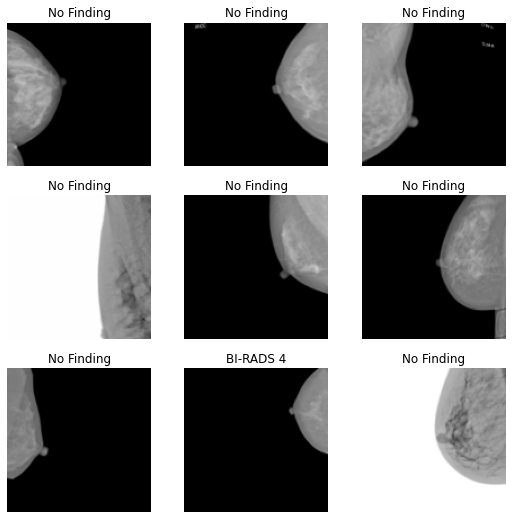

In [101]:
dls.show_batch()
len(dls.train_ds)

In [102]:
learn = vision_learner(dls, arch, metrics=error_rate, path='.').to_fp16() 

/opt/conda/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


SuggestedLRs(valley=0.0020892962347716093, slide=0.0002290867705596611)

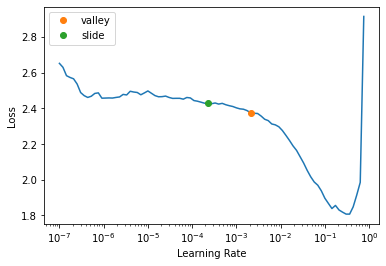

In [103]:
learn.lr_find(suggest_funcs=(valley, slide))

In [104]:
learn.fine_tune(epochs=epochs, base_lr=0.01)

In [105]:
learn.export('models/model.pkl')